<a href="https://colab.research.google.com/github/abdurahman02/AcademicContent/blob/master/FederatedCF022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import os
import copy
import time
import string

In [29]:
!git clone "https://github.com/abdurahman02/ml-latest-small.git"
os.chdir("ml-latest-small")
os.listdir()

Cloning into 'ml-latest-small'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


['.git', 'ratings.csv', 'README.txt', 'movies.csv', 'links.csv', 'tags.csv']

In [30]:
data = pd.read_csv("ratings.csv")

In [31]:
data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [32]:
def filtering_data(df,from_user, to_user, from_item, to_item):
  if(from_user <= to_user and from_item <= to_item
     and to_user < max(df["userId"]) and to_item < max(df["movieId"])
     ):
    return df[(df.userId >= from_user) & 
              (df.userId <= to_user) &
              (df.movieId >= from_item) &
              (df.movieId <= to_item)
              ]
  print("Error Range")

def getBatchForUser(data, u, batchSize):
  if u >= len(data["userId"].unique()):
    print("INvalid UserId requested")
    return
  if batchSize > len(data[data.userId == u]):
    batchSize = len(data[data.userId == u])
  return data[data.userId == u].sample(n=batchSize)

In [33]:
# split train and validation before encoding
# np.random.seed(3)
# msk = np.random.rand(len(data)) < 0.8
# train = data[msk].copy()
# val = data[~msk].copy()

In [34]:
# here is a handy function modified from fast.ai
def proc_col(col, train_col=None):
    """Encodes a pandas column with continous ids. 
    """
    if train_col is not None:
        uniq = train_col.unique()
    else:
        uniq = col.unique()
    name2idx = {o:i for i,o in enumerate(uniq)}
    return name2idx, np.array([name2idx.get(x, -1) for x in col]), len(uniq)
    
def encode_data(df, train=None):
    """ Encodes rating data with continous user and movie ids. 
    If train is provided, encodes df with the same encoding as train.
    """
    df = df.copy()
    for col_name in ["userId", "movieId"]:
        train_col = None
        if train is not None:
            train_col = train[col_name]
        _,col,_ = proc_col(df[col_name], train_col)
        df[col_name] = col
        df = df[df[col_name] >= 0]
    return df

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [36]:
# encoding the train and validation data
# df_train = encode_data(train)
# df_val = encode_data(val, train)

In [37]:
# df_val.movieId.values

In [38]:
# df_train_numpy = df_train.to_numpy(dtype=int, copy=True)
# # print((df_train_numpy))
# diction={}
# for i in range(len(df_train_numpy)):
#   diction[df_train_numpy[i][0],df_train_numpy[i][1]] = df_train_numpy[i][2]

In [39]:
class MF(nn.Module):
    def __init__(self, userX_embedding, item_embed_mat, emb_size=100):
        super(MF, self).__init__()
        self.userX_embedding = userX_embedding
        self.item_embed_mat = item_embed_mat
        # print(userX_embedding.weight)
        
    def forward(self, u, v):
        u = self.userX_embedding(u)
        
        v = self.item_embed_mat(v)
        # print("u: ",u)
        # print("v: ",v)
        # print(len((u*v).sum(1)))
        return (u*v).sum(1)

In [40]:
# emb_size=5
# items = torch.LongTensor(df_train.movieId.unique()) #.cuda()
# embx_item = nn.Embedding(num_items, emb_size)
# embx_user = nn.Embedding(1,emb_size)
# embx_user.weight.data.uniform_(0, 0.05)
# embx_item.weight.data.uniform_(0, 0.05)

# model01 = MF(embx_user,embx_item,5)



In [41]:
# model01.userX_embedding.weight

In [42]:
# pred = model01(torch.tensor([0]), torch.tensor(items[0]))

In [43]:
# model01.item_embed_mat.weight[0]

In [44]:
# print(pred,torch.tensor([diction[0,0]]))

In [45]:
# optimizer = torch.optim.Adam(model01.parameters(), lr=0.01, weight_decay=0.0)
# loss = F.mse_loss(pred,torch.FloatTensor([diction[0,0]]))
# optimizer.zero_grad()
# loss.backward()
# optimizer.step()

In [46]:
# print(model01.item_embed_mat.weight[0])
# print(model01.userX_embedding.weight)

In [47]:
# model = MF(num_users, num_items, emb_size=5) # .cuda() if you have a GPU

In [48]:
# print(len(df_train.movieId.unique()))
# print(max(df_train.movieId.values))

In [49]:
def add_model_parameters(model1, model2):
    # Adds the parameters of model1 to model2

    params1 = model1.named_parameters()
    params2 = model2.named_parameters()

    dict_params2 = dict(params2)

    for name1, param1 in params1:
        if name1 in dict_params2 and name1 != 'userX_embedding.weight':
            dict_params2[name1].data.copy_(param1.data + dict_params2[name1].data)

    model2.load_state_dict(dict_params2)

def sub_model_parameters(model1, model2):
    # Subtracts the parameters of model2 with model1

    params1 = model1.named_parameters()
    params2 = model2.named_parameters()

    dict_params2 = dict(params2)

    for name1, param1 in params1:
        if name1 in dict_params2 and name1 != 'userX_embedding.weight':
            dict_params2[name1].data.copy_(dict_params2[name1].data - param1.data)

    model2.load_state_dict(dict_params2)

def divide_model_parameters(model, f):
    # Divides model parameters except for the user embeddings with f
    params1 = model.named_parameters()
    params2 = model.named_parameters()
    dict_params2 = dict(params2)
    for name1, param1 in params1:
        if name1 != 'userX_embedding.weight':
            dict_params2[name1].data.copy_(param1.data / f)
    model.load_state_dict(dict_params2)

def zero_model_parameters(model):
    # sets all parameters to zero

    params1 = model.named_parameters()
    params2 = model.named_parameters()
    dict_params2 = dict(params2)
    for name1, param1 in params1:
        if name1 in dict_params2:
            dict_params2[name1].data.copy_(param1.data - dict_params2[name1].data)

    model.load_state_dict(dict_params2)

In [50]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [51]:
def fed_train_client(model_server, df_train,epochs=10, lr=0.1):
    
    emb_size=5
    los=[]
    los_usr=[]
    dict_los={}
    user_emb_dict = {}
    item_emb_mat_dict = {}

    
    model_diff = copy.deepcopy(model_server)
    zero_model_parameters(model_diff)
    # model02(torch.tensor([0]), torch.tensor(items[0]))
    t1 = time.time()
    
    for user_id in range(len(df_train.userId.unique())):
        
        model02 = copy.deepcopy(model_server)
        optimizer = torch.optim.Adam(model02.parameters(), lr=lr, weight_decay=1e-5)
        batch = df_train[df_train.userId == user_id]
        batch = batch.to_numpy(dtype=int, copy=True)
        for e in range(epochs):
            for data_point in batch:
                # print(data_point)
                y_hat = model02(torch.tensor([0]), torch.tensor(data_point[1]))

                loss_fn = RMSELoss()
                loss = loss_fn(y_hat,torch.FloatTensor([data_point[2]]))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                los.append(loss.item())
            
            los_usr.append(np.sqrt(np.sum([x**2 for x in los])/len(batch)+1e-6))
            los.clear()
        # running_loss = running_loss/len(data_point)
        user_emb_dict[user_id] = copy.deepcopy(model02.userX_embedding.weight)
        item_emb_mat_dict[user_id] = copy.deepcopy(model02.item_embed_mat.weight)
        
        dict_los[user_id] = los_usr[len(los_usr)-1]
        print("userId:", user_id, "training_loss: ", dict_los[user_id])
        los_usr.clear()

        sub_model_parameters(model_server, model02)
        add_model_parameters(model02, model_diff)
        
    # Take the average of the MLP and item vectors
    divide_model_parameters(model_diff, (len(df_train.userId.unique())))

    # Update the global model by adding the total change
    add_model_parameters(model_diff, model_server)

    t2 = time.time()

    print("Time of round:", round(t2 - t1), "seconds")
    return dict_los
    # test_loss(model, unsqueeze)

In [52]:
def fed_eval(model, df_val):
    los = []
    los_usr = []
    for user_id in range(len(df_val.userId.unique())):
        batch = df_val[df_val.userId == user_id]
        batch = batch.to_numpy(dtype=int, copy=True)
        for data_point in batch:
            y_hat = model(torch.tensor([0]), torch.tensor(data_point[1]))
            # loss = RMSELoss(y_hat,torch.FloatTensor([data_point[2]]))
            loss_fn = RMSELoss()
            loss = loss_fn(y_hat,torch.FloatTensor([data_point[2]]))
            los.append(loss.item())
        los_usr.append(np.sqrt(np.sum([x**2 for x in los])/len(batch)+1e-6))
        los.clear()
    return np.mean(los_usr),los_usr


In [53]:
def Server(from_user, to_user, from_item, to_item, epochs, emb_size, rounds, lr):

 
    Max_BatchSize_User = 20
    lr = lr
    eta = 80
    
    print("embedding size is: ",emb_size)
    print("Max Batch Size is: ",Max_BatchSize_User)

    avg_train_loss = []
    dict_loss_train={}
    avg_test_loss_vec = []
    
    filtered_data = filtering_data(data, from_user, to_user, from_item, to_item)
    np.random.seed(3)
    msk = np.random.rand(len(filtered_data)) < 0.8
    train = filtered_data[msk].copy()
    val = filtered_data[~msk].copy()
    df_train = encode_data(train)
    df_val = encode_data(val, train)

    
    embx_item = nn.Embedding(len(df_train.movieId.unique()), emb_size)
    embx_user = nn.Embedding(1,emb_size)
    if torch.cuda.is_available():
        embx_user.weight.data.uniform_(0, 0.05).cuda()
        embx_item.weight.data.uniform_(0, 0.05).cuda()
    else:
        embx_user.weight.data.uniform_(0, 0.05)
        embx_item.weight.data.uniform_(0, 0.05)
    model_server = MF(embx_user,embx_item,emb_size)

    for t in range(rounds):  # for each round

        print("Starting round", t + 1)
        # train one round
        
        dict_loss_train = fed_train_client(model_server, df_train, epochs=epochs, lr=lr)

        avg_train_loss.append(np.mean([dict_loss_train[x] for x in dict_loss_train]))

        print("Evaluating model...")
        avg_test_loss, test_loss_vec_userX = fed_eval(model_server, df_val)
        avg_test_loss_vec.append(avg_test_loss)
        print("Round ", t, " computed test loss:", avg_test_loss)
    return avg_test_loss_vec, test_loss_vec_userX, avg_train_loss
        

In [ ]:
from_user = 1
to_user = 30
from_item = 1
to_item = 10000
epochs=10
emb_size=10
rounds=20
lr=0.1
avg_test_loss_vec, \
test_loss_vec_userX,\
avg_train_loss = Server(from_user, to_user, 
                        from_item, to_item, 
                        epochs, emb_size, rounds, lr)

embedding size is:  10
Max Batch Size is:  20
Starting round 1
userId: 0 training_loss:  4.010663815363028
userId: 1 training_loss:  0.24108885355863754
userId: 2 training_loss:  2.5073948776802184
userId: 3 training_loss:  3.580183037474199
userId: 4 training_loss:  2.2848651280389114
userId: 5 training_loss:  2.9145358337080562
userId: 6 training_loss:  3.220468490849105
userId: 7 training_loss:  2.971423970868952
userId: 8 training_loss:  2.5332423525506123
userId: 9 training_loss:  2.306696280213099
userId: 10 training_loss:  2.537517145978198
userId: 11 training_loss:  3.1375355933138085
userId: 12 training_loss:  2.712484652763543
userId: 13 training_loss:  2.773393597747776
userId: 14 training_loss:  1.9284036267776337
userId: 15 training_loss:  2.3024681829051454
userId: 16 training_loss:  2.791341318177365
userId: 17 training_loss:  4.261209201038054
userId: 18 training_loss:  4.581336501374574
userId: 19 training_loss:  3.5932919592715247
userId: 20 training_loss:  3.73005100

total users:  2
total items:  9999
Embedding size:  10
local epochs:  10


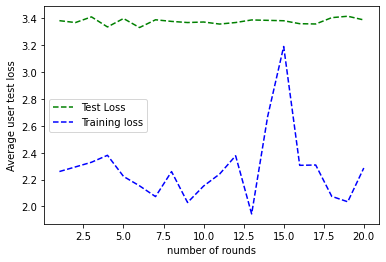

In [62]:

# from_user = 1
# to_user = 3
# from_item = 1
# to_item = 10000
# epochs=10
# emb_size=20
# rounds=100
plt.xlabel('number of rounds')
plt.ylabel('Average user test loss')
print("total users: ", abs(from_user-to_user))
print("total items: ", abs(from_item-to_item))
print("Embedding size: ",emb_size)
print("local epochs: ", epochs)
plt.plot(np.arange(start=1, stop=len(avg_test_loss_vec)+1, step=1), avg_test_loss_vec, 'g--')
plt.plot(np.arange(start=1, stop=len(avg_test_loss_vec)+1, step=1), avg_train_loss, 'b--')
plt.legend(["Test Loss", "Training loss"])

In [56]:
class MF_bias(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100):
        super(MF_bias, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.item_bias = nn.Embedding(num_items, 1)
        self.user_emb.weight.data.uniform_(0,0.05)
        self.item_emb.weight.data.uniform_(0,0.05)
        self.user_bias.weight.data.uniform_(-0.01,0.01)
        self.item_bias.weight.data.uniform_(-0.01,0.01)
        
    def forward(self, u, v):
        U = self.user_emb(u)
        V = self.item_emb(v)
        b_u = self.user_bias(u).squeeze()
        b_v = self.item_bias(v).squeeze()
        return (U*V).sum(1) +  b_u  + b_v

In [57]:
# model = MF_bias(num_users, num_items, emb_size=100) #.cuda()

In [58]:
# train_epocs(model, epochs=10, lr=0.05, wd=1e-5)

In [59]:
# train_epocs(model, epochs=10, lr=0.01, wd=1e-5)

In [60]:
# train_epocs(model, epochs=10, lr=0.001, wd=1e-5)